# Predicting Stock Movements by Analyzing News Data

## Importing Packages

In [2]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

# options

pd.set_option('display.max_columns', None)

## Preparing the News Data

In [3]:
# import news data

df_news = pd.read_csv('data/news_data.csv')
df_news.info()

C:\Users\nicol\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823480 entries, 0 to 823479
Data columns (total 48 columns):
TIMESTAMP_UTC           823480 non-null object
RPNA_DATE_UTC           823480 non-null object
RPNA_TIME_UTC           823480 non-null object
RP_ENTITY_ID            823480 non-null object
ENTITY_TYPE             823480 non-null object
ENTITY_NAME             823480 non-null object
POSITION_NAME           5568 non-null object
RP_POSITION_ID          5568 non-null object
COUNTRY_CODE            823480 non-null object
RELEVANCE               823480 non-null int64
TOPIC                   45300 non-null object
GROUP                   45300 non-null object
TYPE                    45300 non-null object
SUB_TYPE                21440 non-null object
PROPERTY                14679 non-null object
EVALUATION_METHOD       0 non-null float64
MATURITY                0 non-null float64
CATEGORY                45300 non-null object
ESS                     45300 non-null float64
AES            

In [4]:
# change formats

df_news['TICKER'] = df_news['COMPANY'].str[3:]
df_news['TIMESTAMP_UTC'] = pd.to_datetime(df_news['TIMESTAMP_UTC'], utc = True)
df_news['RPNA_DATE_UTC'] = df_news['TIMESTAMP_UTC'].dt.date
df_news['RPNA_TIME_UTC'] = df_news['TIMESTAMP_UTC'].dt.time

In [9]:
# convert UTC to Eastern Standard Time

df_news['TIMESTAMP_EST'] = df_news['TIMESTAMP_UTC'].dt.tz_convert('America/New_York')
df_news['RPNA_DATE_EST'] = df_news['TIMESTAMP_EST'].dt.date
df_news['RPNA_TIME_EST'] = df_news['TIMESTAMP_EST'].dt.time

# get next market day for every observation (news) according to the US trading calendar

from pandas.tseries.offsets import CustomBusinessDay

from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, \
    USMartinLutherKingJr, USPresidentsDay, GoodFriday, USMemorialDay, \
    USLaborDay, USThanksgivingDay

class USTradingCalendar(AbstractHolidayCalendar):
    rules = [Holiday('NewYearsDay', month = 1, day = 1, observance = nearest_workday),
             USMartinLutherKingJr,
             USPresidentsDay,
             GoodFriday,
             USMemorialDay,
             Holiday('USIndependenceDay', month = 7, day = 4, observance = nearest_workday),
             USLaborDay,
             USThanksgivingDay,
             Holiday('Christmas', month = 12, day = 25, observance = nearest_workday)]

bday_us = CustomBusinessDay(calendar = USTradingCalendar())
nasdaq_close = '16:00:00'

df_news['NEXT_MARKET_DATE'] = pd.to_datetime(np.where(df_news['RPNA_TIME_EST'] > pd.to_datetime(nasdaq_close).time(),
                                                      df_news['RPNA_DATE_EST'] + bday_us,
                                                      df_news['RPNA_DATE_EST'] + 0 * bday_us))
df_news['NEXT_MARKET_CLOSE'] = (df_news['NEXT_MARKET_DATE'] + pd.Timedelta(nasdaq_close)).dt.tz_localize('America/New_York')
df_news['TIME_TO_CLOSE'] = df_news['NEXT_MARKET_CLOSE'] - df_news['TIMESTAMP_EST']

df_news[['TIMESTAMP_EST', 'NEXT_MARKET_DATE', 'NEXT_MARKET_CLOSE', 'TIME_TO_CLOSE']].head(5)

'''
the algortihm is working as intended: the stock market was closed from 1st to 3rd January 
-> next market day on 4th January
'''

,TIMESTAMP_EST,NEXT_MARKET_DATE,NEXT_MARKET_CLOSE,TIME_TO_CLOSE
0,2016-01-01 05:30:01.663000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,3 days 10:29:58.337000
1,2016-01-01 05:44:40.104000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,3 days 10:15:19.896000
2,2016-01-03 18:35:51.992000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,0 days 21:24:08.008000
3,2016-01-04 00:08:02.003000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,0 days 15:51:57.997000
4,2016-01-04 02:05:01.705000-05:00,2016-01-04,2016-01-04 16:00:00-05:00,0 days 13:54:58.295000


## Preparing the Market Data

In [83]:
# import market data

df_market = pd.read_csv('data/nasdaq.csv')
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28248 entries, 0 to 28247
Data columns (total 12 columns):
gvkey       28248 non-null int64
iid         28248 non-null int64
datadate    28248 non-null object
tic         28248 non-null object
conm        28248 non-null object
cshtrd      28221 non-null float64
prccd       28221 non-null float64
prchd       28221 non-null float64
prcld       28221 non-null float64
prcod       27876 non-null float64
trfd        28222 non-null float64
exchg       28248 non-null int64
dtypes: float64(6), int64(3), object(3)
memory usage: 2.6+ MB


In [84]:
# change formats

df_market['datadate'] = pd.to_datetime(df_market['datadate'],
                                       dayfirst = True)

In [85]:
# compute stock return and volatility

df_market['dreturn'] = np.log(df_market.prccd / df_market.prcod)
df_market['dvar'] = ((np.log(df_market.prchd) - np.log(df_market.prcld))**2) / 4 * np.log(2) #Applying the Parkinson (1980) H-L measure
df_market['dvol'] = np.sqrt(df_market.dvar)
df_market['dreturn_flag'] = np.where(df_market['dreturn'] > 0, 1, 0)

## Joining News and Market Data

In [86]:
# join news data and market data on market date and company

df = pd.merge(df_news, df_market, how = 'inner',
              left_on = ['NEXT_MARKET_DATE', 'TICKER'],
              right_on = ['datadate', 'tic'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785719 entries, 0 to 785718
Data columns (total 71 columns):
TIMESTAMP_UTC           785719 non-null datetime64[ns, UTC]
RPNA_DATE_UTC           785719 non-null object
RPNA_TIME_UTC           785719 non-null object
RP_ENTITY_ID            785719 non-null object
ENTITY_TYPE             785719 non-null object
ENTITY_NAME             785719 non-null object
POSITION_NAME           5150 non-null object
RP_POSITION_ID          5150 non-null object
COUNTRY_CODE            785719 non-null object
RELEVANCE               785719 non-null int64
TOPIC                   42546 non-null object
GROUP                   42546 non-null object
TYPE                    42546 non-null object
SUB_TYPE                20285 non-null object
PROPERTY                13939 non-null object
EVALUATION_METHOD       0 non-null float64
MATURITY                0 non-null float64
CATEGORY                42546 non-null object
ESS                     42546 non-null float64
AE

## Data Cleaning

In [87]:
# drop columns with no explanatory worth

drop = ['TIMESTAMP_UTC', 'RPNA_DATE_UTC', 'RPNA_TIME_UTC', 'RP_ENTITY_ID',
        'ENTITY_TYPE', 'ENTITY_NAME', 'RP_POSITION_ID', 'COUNTRY_CODE',
        'EVALUATION_METHOD', 'ENS_KEY', 'G_ENS_KEY', 'EVENT_SIMILARITY_KEY',
        'RP_STORY_ID', 'PRODUCT_KEY', 'COMPANY', 'ISIN', 'BER', 'ANL_CHG',
        'TICKER', 'NEXT_MARKET_DATE', 'NEXT_MARKET_CLOSE', 'gvkey', 'iid', 'datadate', 'tic',
        'conm', 'cshtrd', 'prccd', 'prchd', 'prcld', 'prcod', 'trfd', 'exchg']
df = df.drop(drop, axis = 1)

In [88]:
# show missing data in rows

missing = (df.isnull().sum(axis = 1) / df.isnull().count(axis = 1)).sort_values(ascending = False)
missing_rows = pd.concat([missing], axis = 1, keys = ['Missing'])
drop_rows = missing_rows[missing_rows['Missing'] > 0.25]
drop_rows.count()

Missing    743173
dtype: int64

In [89]:
# drop observations where most features are missing

df = df.drop(drop_rows.index, axis = 0)

In [90]:
# show missing data in columns

total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending = False)
missing_clmns = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_clmns.head(5)

,Total,Percent
MATURITY,42546,1.000000
POSITION_NAME,37396,0.878955
PROPERTY,28607,0.672378
SUB_TYPE,22261,0.523222
AES,0,0.000000


In [91]:
# drop features where most observations are missing

df = df.drop((missing_clmns[missing_clmns['Percent'] > 0.25]).index, axis = 1)

In [92]:
# check if missing values remain

df.isnull().sum().max()

0

## Data Exploration

C:\Users\nicol\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


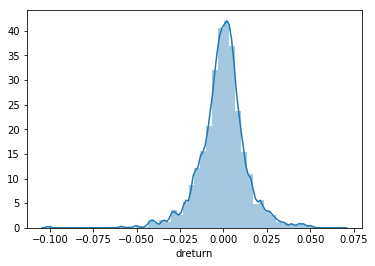

In [93]:
# check distribution of return

sns.distplot(df['dreturn']);

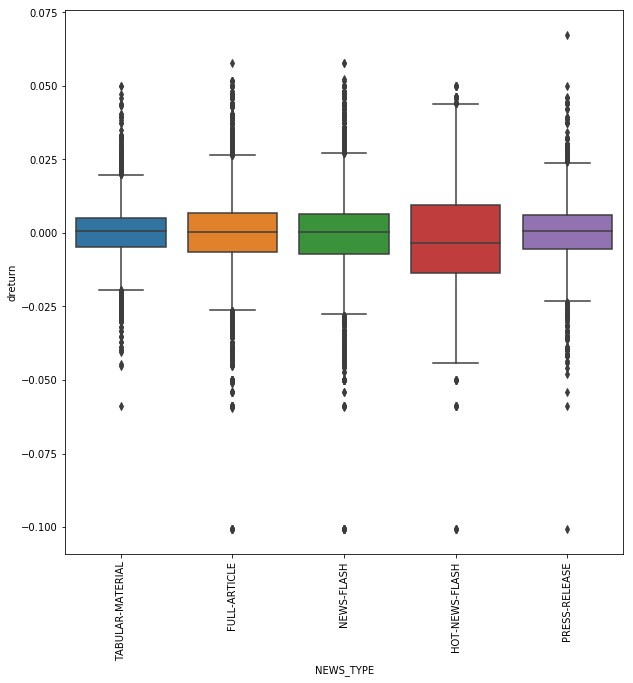

In [94]:
var_x = 'NEWS_TYPE'
var_y = 'dreturn'
data = pd.concat([df[var_x], df[var_y]], axis = 1)
plt.subplots(figsize = (10, 10))
fig = sns.boxplot(x = var_x, y = var_y, data = data)
plt.xticks(rotation = 90);

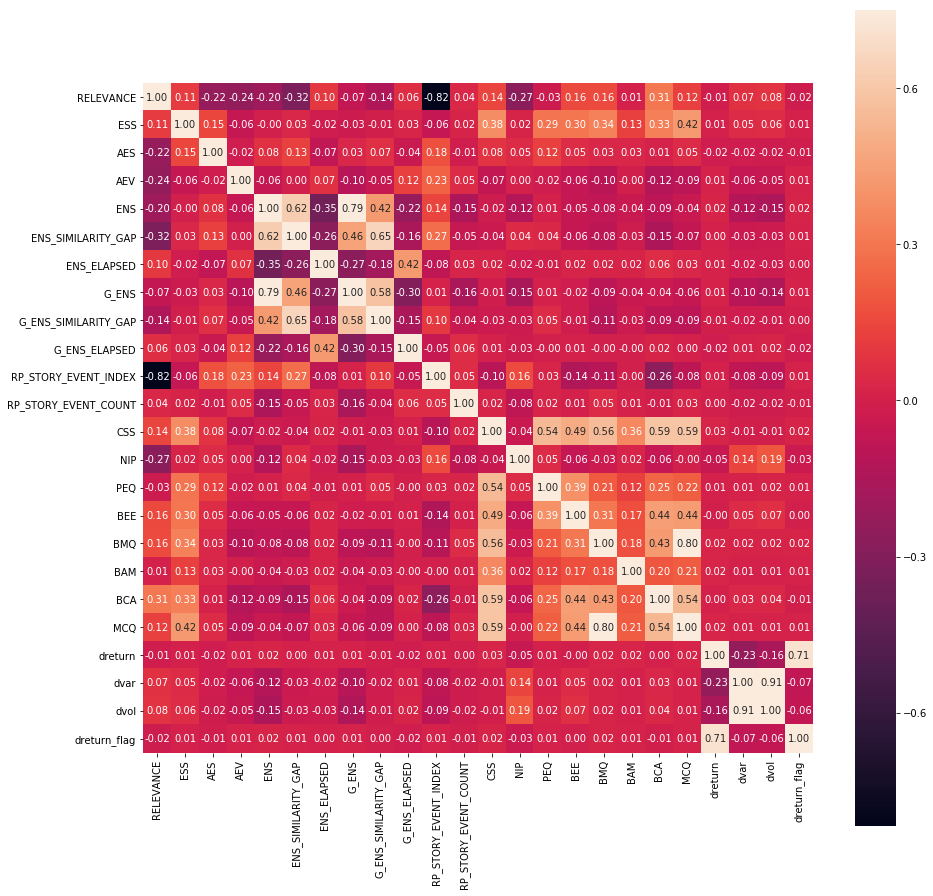

In [95]:
# check correlation of all variables

corrmat = df.corr()
plt.subplots(figsize = (15, 15))
sns.heatmap(corrmat, vmax = 0.75, square = True, annot = True, fmt='.2f');

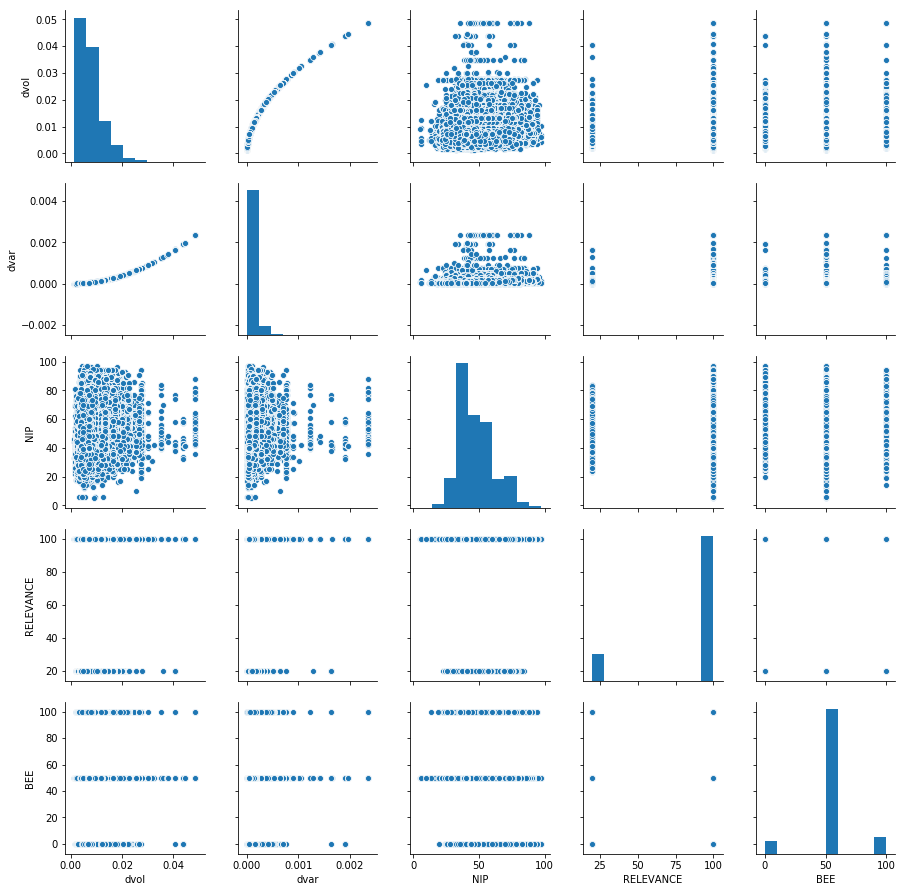

In [96]:
# visualize relationship between the most correlated variables

cols = corrmat.nlargest(5, 'dvol')['dvol'].index
sns.pairplot(df[cols])
plt.show()

In [97]:
# transform nominal features to dummy features

# df = pd.get_dummies(df)

## Model Selection

In [98]:
# split the dataset into training data and test data

X = df[['ESS', 'ENS', 'NIP', 'PEQ', 'BEE']]
Y = df['dreturn_flag']
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, random_state = 0)
X_train.shape, X_test.shape

((31909, 5), (10637, 5))

In [100]:
# compare different classifiers

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

classifiers = [
    LogisticRegression(),
    RandomForestClassifier(),
    SVC(),
    GaussianNB(),
    KNeighborsClassifier()
    ]

clf_columns = [
    'Name',
    'Train Accuracy',
    'Test Accuracy',
    ]

clf_table = pd.DataFrame(columns = clf_columns)


for i, clf in enumerate(classifiers):
    
    clf_name = clf.__class__.__name__
    clf_table.loc[i, 'Name'] = clf_name
    
    pipe = make_pipeline(StandardScaler(), clf)
    
    pipe.fit(X_train, Y_train)
    
    clf_table.loc[i, 'Train Accuracy'] = pipe.score(X_train, Y_train)
    clf_table.loc[i, 'Test Accuracy'] = pipe.score(X_test, Y_test)

clf_table.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)
clf_table

,Name,Train Accuracy,Test Accuracy
1,RandomForestClassifier,0.685575,0.545267
2,SVC,0.535084,0.519319
3,GaussianNB,0.515685,0.514619
0,LogisticRegression,0.521514,0.513021
4,KNeighborsClassifier,0.595725,0.509824
